In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
df = pd.read_csv("sales_data_sample.csv", encoding='latin1')  # replace with your actual file
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [3]:
df['YearMonth'] = df['ORDERDATE'].dt.to_period('M')
monthly_demand = df.groupby(['PRODUCTCODE', 'YearMonth'])['QUANTITYORDERED'].sum().reset_index()
monthly_demand['YearMonth'] = monthly_demand['YearMonth'].astype(str)


In [4]:
# Find top 5 products by total demand
top_products = monthly_demand.groupby('PRODUCTCODE')['QUANTITYORDERED'].sum().sort_values(ascending=False).head(20)
print(top_products)

# Let's pick the top product
target_product = top_products.index[1]
df_product = monthly_demand[monthly_demand['PRODUCTCODE'] == target_product]


PRODUCTCODE
S18_3232     1774
S24_3856     1052
S18_4600     1031
S700_4002    1029
S12_4473     1024
S24_3949     1008
S18_1097      999
S50_1341      999
S18_2432      998
S18_3856      997
S18_1342      997
S24_2300      996
S18_2319      993
S18_2949      991
S700_2610     990
S24_2840      983
S50_1392      979
S24_1444      976
S700_2824     976
S12_1108      973
Name: QUANTITYORDERED, dtype: int64


In [5]:
%pip install prophet

In [6]:
from prophet import Prophet


In [7]:
df_prophet = df_product[['YearMonth', 'QUANTITYORDERED']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


In [8]:
model = Prophet()
model.fit(df_prophet)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69hjz8lo/xpbk3t85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69hjz8lo/99ed8s0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8619', 'data', 'file=/tmp/tmp69hjz8lo/xpbk3t85.json', 'init=/tmp/tmp69hjz8lo/99ed8s0y.json', 'output', 'file=/tmp/tmp69hjz8lo/prophet_modelwq7yefjd/prophet_model-20250714131738.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:17:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


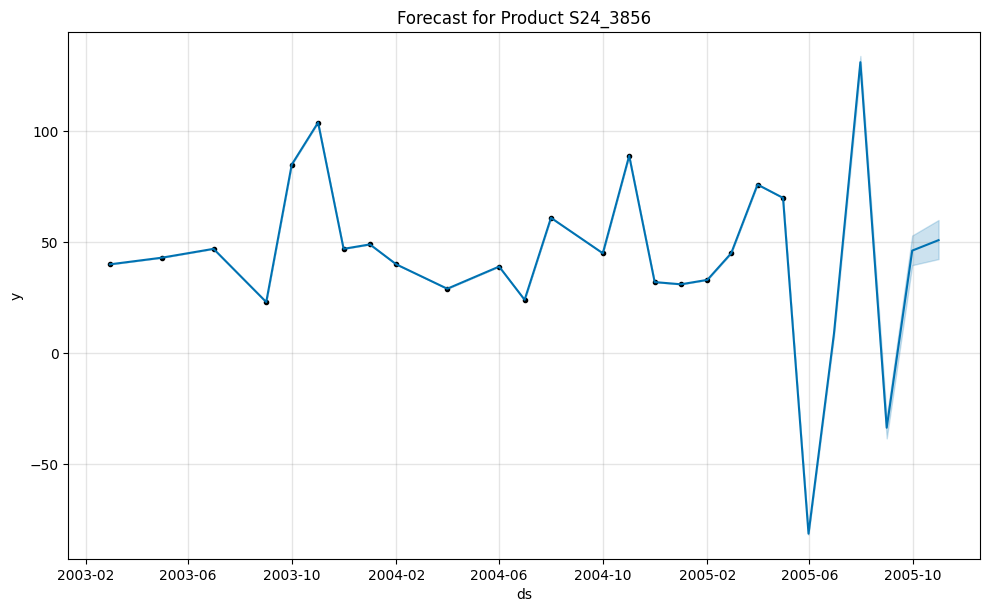

In [9]:
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)
model.plot(forecast)
plt.title(f"Forecast for Product {target_product}")
plt.show()


In [10]:
train = df_prophet.iloc[:-3]
test = df_prophet.iloc[-3:]

model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=3, freq='M')
forecast = model.predict(future)

# Compare forecast to actual
forecast_tail = forecast[['ds', 'yhat']].tail(3).reset_index(drop=True)
actual_tail = test.reset_index(drop=True)

comparison = pd.concat([actual_tail, forecast_tail['yhat']], axis=1)
comparison['error'] = abs(comparison['y'] - comparison['yhat'])
comparison['APE'] = (comparison['error'] / comparison['y']) * 100
MAPE = comparison['APE'].mean()
print("MAPE (Mean Absolute Percentage Error):", round(MAPE, 2), "%")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69hjz8lo/_o41uut0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69hjz8lo/usm0szy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54284', 'data', 'file=/tmp/tmp69hjz8lo/_o41uut0.json', 'init=/tmp/tmp69hjz8lo/usm0szy4.json', 'output', 'file=/tmp/tmp69hjz8lo/prophet_modeldain9_1x/prophet_model-20250714131801.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:18:01 - cmdstanpy - INFO - Chain [1] start processing
I

MAPE (Mean Absolute Percentage Error): 28.91 %


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [11]:
results = []

for product in top_products.index:  # or use any product list
    df_p = monthly_demand[monthly_demand['PRODUCTCODE'] == product][['YearMonth', 'QUANTITYORDERED']]
    df_p.columns = ['ds', 'y']
    df_p['ds'] = pd.to_datetime(df_p['ds'])

    if len(df_p) < 12:  # skip if insufficient data
        continue

    train = df_p.iloc[:-3]
    test = df_p.iloc[-3:]

    model = Prophet()
    model.fit(train)

    future = model.make_future_dataframe(periods=3, freq='M')
    forecast = model.predict(future)

    yhat = forecast[['ds', 'yhat']].tail(3).reset_index(drop=True)
    actual = test.reset_index(drop=True)

    merged = pd.concat([actual, yhat['yhat']], axis=1)
    merged['error'] = abs(merged['y'] - merged['yhat'])
    merged['APE'] = (merged['error'] / merged['y']) * 100
    mape = merged['APE'].mean()

    results.append({
        'PRODUCTCODE': product,
        'MAPE': round(mape, 2)
    })

df_results = pd.DataFrame(results)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69hjz8lo/i2zhj873.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69hjz8lo/h3089smb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73527', 'data', 'file=/tmp/tmp69hjz8lo/i2zhj873.json', 'init=/tmp/tmp69hjz8lo/h3089smb.json', 'output', 'file=/tmp/tmp69hjz8lo/prophet_modelgt05qohd/prophet_model-20250714131801.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:18:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [12]:
df_results.sort_values(by='MAPE')


,PRODUCTCODE,MAPE
9,S18_3856,10.94
1,S24_3856,28.91
15,S24_2840,35.73
14,S700_2610,40.44
8,S18_2432,43.07
4,S12_4473,47.02
18,S700_2824,48.94
2,S18_4600,55.10
16,S50_1392,55.51
3,S700_4002,57.95


In [13]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

product_codes = monthly_demand['PRODUCTCODE'].unique()
forecast_results = []
mape_list = []


In [14]:
for code in product_codes:
    df_product = monthly_demand[monthly_demand['PRODUCTCODE'] == code][['YearMonth', 'QUANTITYORDERED']].copy()
    df_product.columns = ['ds', 'y']
    df_product['ds'] = pd.to_datetime(df_product['ds'])

    if len(df_product) < 6:  # Skip if too little data
        continue

    try:
        # Train/test split
        train = df_product[:-3]
        test = df_product[-3:]

        model = Prophet()
        model.fit(train)

        future = model.make_future_dataframe(periods=3, freq='M')
        forecast = model.predict(future)

        forecasted = forecast[['ds', 'yhat']].tail(3).reset_index(drop=True)
        actual = test.reset_index(drop=True)

        comparison = pd.concat([actual, forecasted['yhat']], axis=1)
        comparison['error'] = abs(comparison['y'] - comparison['yhat'])
        comparison['APE'] = (comparison['error'] / comparison['y']) * 100
        MAPE = comparison['APE'].mean()

        mape_list.append({'PRODUCTCODE': code, 'MAPE': MAPE})

        # Save forecast
        forecast['PRODUCTCODE'] = code
        forecast_results.append(forecast)

    except Exception as e:
        print(f"Error for product {code}: {e}")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69hjz8lo/x3ruyrgv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69hjz8lo/jbmpe6c0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59881', 'data', 'file=/tmp/tmp69hjz8lo/x3ruyrgv.json', 'init=/tmp/tmp69hjz8lo/jbmpe6c0.json', 'output', 'file=/tmp/tmp69hjz8lo/prophet_modelm41zr_jd/prophet_model-20250714131946.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [15]:
mape_df = pd.DataFrame(mape_list)
forecast_all_df = pd.concat(forecast_results, ignore_index=True)


In [16]:
good_forecasts = mape_df[mape_df['MAPE'] < 40]  # Threshold
print("Products with reliable forecast:", good_forecasts.shape[0])


Products with reliable forecast: 24


In [17]:
print("List of Products with MAPE < 40%:\n")
print(good_forecasts.sort_values(by='MAPE'))

List of Products with MAPE < 40%:

    PRODUCTCODE       MAPE
72     S24_3371   7.380725
46     S18_3856  10.939478
90     S32_4485  13.466607
68     S24_2887  14.125469
23     S18_1889  15.848975
24     S18_1984  18.368392
97    S700_1938  23.558784
93     S50_1514  24.598969
36     S18_3029  28.135760
76     S24_3856  28.913730
20     S18_1589  29.079147
70     S24_3151  30.400381
10     S12_3148  32.890322
53     S18_4933  32.957070
108    S72_3212  33.439771
54     S24_1046  33.580759
17     S18_1129  35.132688
65     S24_2766  35.332591
66     S24_2840  35.728420
98    S700_2047  35.838356
85     S32_2206  37.250367
44     S18_3685  38.275964
74     S24_3432  38.355982
57     S24_1628  39.524017


In [18]:
reliable_products = mape_df[mape_df['MAPE'] < 40]['PRODUCTCODE'].tolist()

rop_data = []

for code in reliable_products:
    df_prod = monthly_demand[monthly_demand['PRODUCTCODE'] == code].copy()
    monthly_demand_values = df_prod['QUANTITYORDERED'].values[-6:]  # recent 6 months

    mean_demand = np.mean(monthly_demand_values)
    std_demand = np.std(monthly_demand_values)

    lead_time_month = 0.25  # Assuming 1 week lead time

    demand_during_lead_time = mean_demand * lead_time_month
    safety_stock = 1.65 * std_demand * np.sqrt(lead_time_month)  # 95% service level

    reorder_point = demand_during_lead_time + safety_stock

    rop_data.append({
        'PRODUCTCODE': code,
        'MeanMonthlyDemand': mean_demand,
        'DemandDuringLeadTime': demand_during_lead_time,
        'SafetyStock': safety_stock,
        'ReorderPoint': reorder_point
    })


In [19]:
rop_df = pd.DataFrame(rop_data)
rop_df = rop_df.round(2)
print(rop_df)

   PRODUCTCODE  MeanMonthlyDemand  DemandDuringLeadTime  SafetyStock  \
0     S12_3148              60.00                 15.00        20.84   
1     S18_1129              40.50                 10.12         8.21   
2     S18_1589              55.33                 13.83        26.63   
3     S18_1889              53.83                 13.46        26.82   
4     S18_1984              35.50                  8.88         5.17   
5     S18_3029              46.33                 11.58        15.02   
6     S18_3685              52.67                 13.17        19.05   
7     S18_3856              62.00                 15.50        26.45   
8     S18_4933              40.33                 10.08        11.85   
9     S24_1046              41.50                 10.38        18.26   
10    S24_1628              51.83                 12.96        18.02   
11    S24_2766              52.17                 13.04        19.88   
12    S24_2840              54.50                 13.62         

In [20]:
rop_df.to_excel("reorder_points.xlsx", index=False)


In [21]:
forecast_results.append(forecast)


In [22]:
forecast_all_df = pd.concat(forecast_results, ignore_index=True)


In [23]:
print(forecast_all_df.head())
print(forecast_all_df.columns)

          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2003-02-01  42.569742   30.000010   30.000010    42.569742    42.569742   
1 2003-05-01  42.849955   33.999931   33.999931    42.849955    42.849955   
2 2003-07-01  43.018896   40.999981   40.999981    43.018896    43.018896   
3 2003-08-01  43.249824   44.999832   44.999832    43.249824    43.249824   
4 2003-10-01  43.632070   84.999952   84.999952    43.632070    43.632070   

   additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0      -12.569732            -12.569732            -12.569732 -12.569732   
1       -8.850025             -8.850025             -8.850025  -8.850025   
2       -2.018915             -2.018915             -2.018915  -2.018915   
3        1.750009              1.750009              1.750009   1.750009   
4       41.367882             41.367882             41.367882  41.367882   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    -12.569732    -12.56

In [24]:
from datetime import datetime

# Get the next forecast month
next_month = pd.to_datetime(forecast_all_df['ds']).max().strftime('%Y-%m')

# Filter only that month
forecast_next = forecast_all_df.copy()
forecast_next['ds'] = pd.to_datetime(forecast_next['ds'])
forecast_next['YearMonth'] = forecast_next['ds'].dt.strftime('%Y-%m')
forecast_next = forecast_next[forecast_next['YearMonth'] == next_month]

# Keep only useful columns
forecast_next = forecast_next[['PRODUCTCODE', 'ds', 'yhat']]
forecast_next.rename(columns={'yhat': 'ForecastedDemand'}, inplace=True)


In [25]:
final_df = pd.merge(forecast_next, rop_df, on='PRODUCTCODE', how='inner')
final_df = final_df.round(2)
print(final_df.head())


  PRODUCTCODE         ds  ForecastedDemand  MeanMonthlyDemand  \
0    S18_1129 2005-04-30             55.29              40.50   
1    S18_1889 2005-04-30             46.91              53.83   
2    S18_1984 2005-04-30             40.52              35.50   
3    S24_3856 2005-04-30             42.48              47.83   

   DemandDuringLeadTime  SafetyStock  ReorderPoint  
0                 10.12         8.21         18.33  
1                 13.46        26.82         40.28  
2                  8.88         5.17         14.04  
3                 11.96        15.24         27.20  


In [26]:
final_df.to_excel("inventory_forecast_and_reorder.xlsx", index=False)


In [27]:
# Filter forecast_all_df for the 24 reliable products
forecast_reliable_products = forecast_all_df[forecast_all_df['PRODUCTCODE'].isin(reliable_products)]

# Display the filtered DataFrame
print("Forecasts for Products with MAPE < 40%:")
display(forecast_reliable_products.head())
print(f"\nTotal number of forecast rows for reliable products: {len(forecast_reliable_products)}")
print(f"Number of unique reliable products in forecast data: {forecast_reliable_products['PRODUCTCODE'].nunique()}")

Forecasts for Products with MAPE < 40%:


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,PRODUCTCODE
214,2003-01-01,35.731794,4.037566,67.607537,35.731794,35.731794,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,35.731794,S12_3148
215,2003-04-01,37.945084,7.279762,70.205645,37.945084,37.945084,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,37.945084,S12_3148
216,2003-06-01,39.445203,10.575962,74.252179,39.445203,39.445203,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,39.445203,S12_3148
217,2003-08-01,40.945323,9.987392,73.088918,40.945323,40.945323,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,40.945323,S12_3148
218,2003-09-01,41.707678,10.372516,73.474057,41.707678,41.707678,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,41.707678,S12_3148



Total number of forecast rows for reliable products: 498
Number of unique reliable products in forecast data: 24


In [28]:
print(forecast_next['PRODUCTCODE'].nunique())
print(forecast_next['ds'].unique())


28
<DatetimeArray>
['2005-04-30 00:00:00']
Length: 1, dtype: datetime64[ns]


In [29]:
# Get latest forecast for each product
latest_forecasts = (
    forecast_all_df
    .sort_values(['PRODUCTCODE', 'ds'])
    .groupby('PRODUCTCODE')
    .tail(1)
    [['PRODUCTCODE', 'ds', 'yhat']]
    .rename(columns={'yhat': 'ForecastedDemand'})
)


In [30]:
final_df = pd.merge(latest_forecasts, rop_df, on='PRODUCTCODE', how='inner')
final_df = final_df.round(2)
final_df.to_excel("inventory_forecast_and_reorder.xlsx", index=False)
